# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from torch import nn
from collections import defaultdict
import copy

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = True

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data

# Train classifier

## General definitions

In [5]:
loss_criterion = nn.NLLLoss()

class manual_Scheduler():
    def __init__(self,optimizer):
        self.optimizer = optimizer
    def step(self,epoch):
        if epoch <150:
            self.optimizer.param_groups[0]['lr'] = 0.1
        elif epoch <250:
            self.optimizer.param_groups[0]['lr'] = 0.01
        elif epoch<350:
            self.optimizer.param_groups[0]['lr'] = 0.001

#risk_dict = {'selective_risk_mcp':  lambda x,label: unc_comp.selective_risk(x,label,unc_type = unc.MCP_unc)}

In [6]:
import sys
sys.path.insert(1, r'/home/luis-felipe/pytorch-cifar/models')
from resnet import ResNet50

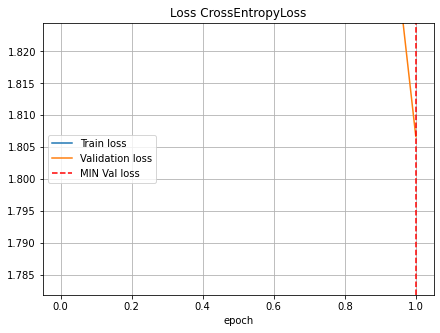

Acc_val (max): 9.84 (9.84) | Loss: 2.3028 | Acc_train: 10.01 |Progress::   0%|          | 0/200 [01:33<?, ?it/…

KeyboardInterrupt: 

In [8]:
loss_criterion = nn.CrossEntropyLoss()
datasets = ['Cifar10']
models_list = ['ResNet50']#,'ResNet18','ResNet34','ResNet101']
for MODEL_ARC in models_list:
    for DATA in datasets:
        for DP_RATE in [0]:
            name = MODEL_ARC+'_'+DATA+'_Dropout' if DP_RATE else MODEL_ARC+'_'+DATA
            data = torch_data.__dict__[DATA](data_dir = DATA_PATH)
            model_class = models.__dict__[MODEL_ARC]

            model = ResNet50(num_classes = data.n_classes).to(dev)
            
            
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

            model_trainer = TE.Trainer(model,optimizer,loss_criterion, data.train_dataloader,data.test_dataloader,lr_scheduler = scheduler)

            model_trainer.fit(data.train_dataloader,200, live_plot = True,save_checkpoint = False, PATH = PATH_MODELS)
            
            acc = TE.model_acc(model,data.train_dataloader)
            print('Conjunto de treinamento: acc = ', acc)
            acc = TE.model_acc(model,data.test_dataloader)
            print('Conjunto de teste: acc = ', acc)

In [ ]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from models import *
sys.path.insert(1, r'/home/luis-felipe/pytorch-cifar')
from utils import progress_bar


parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true',
                    help='resume from checkpoint')
args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
# net = VGG('VGG19')
net = ResNet50()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
#net = SimpleDLA()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc


for epoch in range(start_epoch, start_epoch+200):
    train(epoch)
    test(epoch)
    scheduler.step()

In [ ]:
loss_criterion = nn.CrossEntropyLoss()
datasets = ['Cifar10']
models_list = ['ResNet50']#,'ResNet18','ResNet34','ResNet101']
for MODEL_ARC in models_list:
    for DATA in datasets:
        for DP_RATE in [0]:
            name = MODEL_ARC+'_'+DATA+'_Dropout' if DP_RATE else MODEL_ARC+'_'+DATA
            data = cifar_data.__dict__[DATA](data_dir = DATA_PATH)
            model_class = models.__dict__[MODEL_ARC]

            model = model_class(num_classes = data.n_classes,softmax = False,name = name,drop_rate = DP_RATE).to(dev)
            
            
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

            model_trainer = TE.Trainer(model,optimizer,loss_criterion, data.train_dataloader,data.test_dataloader,lr_scheduler = scheduler)

            model_trainer.fit(data.train_dataloader,200, live_plot = True,save_checkpoint = True, PATH = PATH_MODELS)
            
            acc = TE.model_acc(model,data.train_dataloader)
            print('Conjunto de treinamento: acc = ', acc)
            acc = TE.model_acc(model,data.test_dataloader)
            print('Conjunto de teste: acc = ', acc)